# 1. 回归问题
假设为有 N 个数据的数据集：$(x_1, y_1), (x_2, y_2), \cdots, (x_N, y_N)$，记为 $\mathcal{D} = \{X, \mathbf{y}\}$。这里 $x_i$ 是列向量（$n$ 元变量），$y_i$ 是标量。我们的目标是，如何根据这些已知的数据 ，对于任意未知的 $x$，估计其相应的目标值 $y$。

## 1.1 线性回归模型

最常用的回归方法是线性回归，即假设输入和输出满足线性关系：
$$
f(x) = x^T  w
$$

$$
y = f(x) + \epsilon
$$



其中， $w$ 是模型的参数，$\epsilon \sim \mathcal{N}(0, \sigma^2)$ 是观测噪声。

在上述模型中，模型就由其参数唯一决定，不同的参数 $w$ 对应一个具体的线性模型。模型学习的过程即是利用训练数据（已知数据）估计参数 $w$ 的过程。

## 1.2 最大似然估计

由于 $\epsilon$ 服从高斯分布，容易计算 $y$ 的似然：

$$
p(y|X, w) = \prod_{i=1}^n p(y_i | x_i, w) = \prod_{i=1}^n \frac{1}{\sqrt{2\pi} \sigma} \exp(-\frac{(y_i - x_i^T w)^2}{2\sigma^2}) = \mathcal{N}(X^Tw, \sigma^2I)
$$

$$
\ln p(y|X, w) = -\frac{n}{2}\ln(2\pi\sigma^2) - \frac{1}{2\sigma^2}|y - X^Tw|^2
$$

通过**最大化对数似然**，可以估计 $w$ 的值，这是关于 $w$ 是二次优化问题，存在唯一的全局最优解，并可以解析地求得：

$$
\hat w = (XX^T)^{-1}Xy
$$

除了直接求解，实际中，可以会使用随机梯度下降法等进行优化。

对于任意输入 $x_*$，可以预测输出 $y_* = x_*^T \hat w $

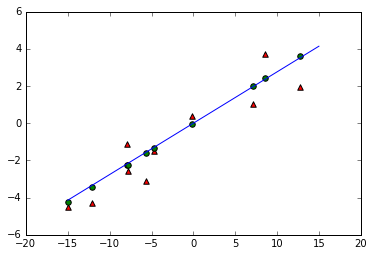

In [1]:
from __future__ import print_function
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
np.random.seed(1111)

N = 10  # number of samples
n = 1  # 1 dimension for visualization

# synthesized data
sigma_noise = 1
X = (np.random.rand(n, N) - 0.5) * 30
w = np.random.randn(n)
y = np.matmul(w, X) + np.random.randn(N) * sigma_noise

# estimated parameters
w_hat = np.matmul(np.linalg.inv(np.dot(X, X.T)), np.dot(X, y))
y_hat = np.matmul(w_hat, X)

plt.scatter(X, y, c='r', s=30, marker='^')
plt.scatter(X, y_hat, c='g', s=30, marker='o')
x_start, x_end = -15, 15
y_start, y_end = x_start * w, x_end * w

plt.plot([x_start, x_end], [y_start, y_end])

## 1.3 最大后验概率估计

最大似然估计只能给出 $w$ 的点估计，对于模型的不确定性并不能告诉我们太多。下面我们从贝叶斯的角度处理参数的估计。

假设 $w \sim \mathcal{N}(0, \Sigma_p)$，即 $w$ 先验是高斯的。
$w$ 的后验概率可以表达为：
$$
p(w|y, X) = \frac{p(y|X, w)p(w)}{p(y|X)} \propto p(y|X, w)p(w)
$$
其中，$p(y|X) = \int p(y|X, w)p(w)dw$


经过推导可以得到：
$$
p(w|X, y) \sim \mathcal{N}(\bar w, A^{-1})
$$

其中，$A = \frac{1}{\sigma^2}XX^T + \Sigma_p^{-1}$，$\bar w = \frac{1}{\sigma^2} A^{-1}Xy$。

对于 $x_*$，$f_*$ 的概率分布：
$$
p(f_*|x_*,X,y) = \int p(f|x_*,w)p(w|X,y) dw = \mathcal{N}(\frac{1}{\sigma^2} x_*^T A^{-1}Xy, x_*^TA^{-1}x_*)
$$

根据上式，我们不但可以估计输入 $x_*$ 的预测值（期望 $\frac{1}{\sigma^2} x_*^T A^{-1}Xy$），还可以给出预测的不确定性（方差 $x_*^TA^{-1}x_*$）。




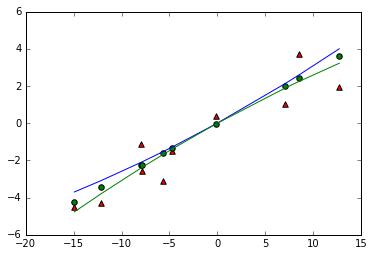

In [2]:
sigma_w = 1
Sigma_p = np.eye(n) * sigma_w ** 2
A = 1. / sigma_noise ** 2 * np.dot(X, X.T) + np.linalg.inv(Sigma_p)
A_inv = np.linalg.inv(A)
w_mean = np.matmul(np.dot(A_inv, X), y) / sigma_noise ** 2
y_mean = np.matmul(w_mean, X)
y_var = np.diag(np.matmul(np.matmul(X.T, A_inv), X))
y_up = y_mean + 2 * y_var
y_down = y_mean - 2 * y_var

x_axis = X.ravel()
idx = np.argsort(x_axis)
x_axis_sorted = x_axis[idx]
y_up = y_up[idx]
y_down = y_down[idx]

plt.scatter(x_axis, y, c='r', s=30, marker='^')
plt.scatter(x_axis, y_mean, c='g', s=30, marker='o')

plt.plot(x_axis_sorted, y_up)
plt.plot(x_axis_sorted, y_down)

## 1.4 基于核函数（kernel）的对偶表示

基于以上讨论，对于给定数据，我们可以求得 $A^{-1}$ （$n \times n$ 矩阵）以及 $\hat w = \frac{1}{\sigma^2} A^{-1}Xy$（$n$ 维向量）。无论数据量的大小，参数量是固定的。

还可以从另一个角度来解释上式。
记 $\alpha = \frac{1}{\sigma^2} x_*^T A^{-1}X$，则 $\bar f_* = \alpha \cdot y$，即预测值是已知数据的线性加权。
下面将看到，从这个解释出发，我们可以引入“核”。


记 $k(x, x^\prime) = x^T\Sigma_px^\prime$（称为**核函数或协方差函数**），$K = X^T\Sigma_pX = k(X, X)$，$k_* = k(x_*,X)$，$k_{**} = k(x_*, x_*)$，则：
$$
p(f_*|x_*,X,y) \sim \mathcal{N}(k_*(K + \sigma^2I)^{-1} y, k_{**} - k_* (K + \sigma^2 I)^{-1}k_*^T)
$$

$y$ 的加权系数为 $\alpha = k_*(K + \sigma^2I)^{-1}$，预测结果的协方差矩阵为 $k_{**} - k_* (K + \sigma^2 I)^{-1}k_*^T$。

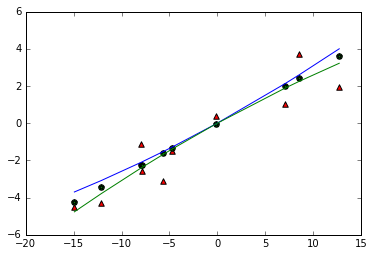

In [3]:
def kernel(x, x_p, Sigma):
    return np.matmul(np.matmul(x.T, Sigma), x_p)

K = kernel(X, X, Sigma_p)
x_star = X # np.random.rand(n, 10) * 30
k_star = kernel(x_star, X, Sigma_p)
k_stars = kernel(x_star, x_star, Sigma_p)

alpha = np.matmul(k_star, np.linalg.inv(K + np.eye(N) * sigma_noise ** 2))
y_star = np.matmul(alpha, y)

plt.scatter(X, y, c='r', s=30, marker='^')
plt.scatter(x_star, y_star, c='g', s=30, marker='o')
plt.scatter(X, y_mean, c='g', s=30, marker='*')

y_var = k_stars - np.matmul(np.matmul(k_star, np.linalg.inv(K + np.eye(N) * sigma_noise ** 2)), k_star.T)
y_var = np.diag(y_var)
y_up = y_star + 2 * y_var
y_down = y_star - 2 * y_var

x_axis = X.ravel()
idx = np.argsort(x_axis)
x_axis = x_axis[idx]
y_up = y_up[idx]
y_down = y_down[idx]

plt.plot(x_axis, y_up)
plt.plot(x_axis, y_down)

上式中，只涉及输入空间中的核函数运算。

## 1.3 特征空间映射

线性模型的建模能力有限，一旦实际的数据不满足线性关系，模型的预测精确可能会很差。
通常可以将输入通过非线性变换，映射到更高维度的特征空间，在新的特征空间，可能能用线性模型较好的表示：
$$
\varPhi: x \to x^\prime, \ \ x \in \mathbb{R}^m, x^\prime \in \mathbb{R}^n 
$$
$$
y = \varPhi(x)^T w
$$

![](https://images0.cnblogs.com/blog/486315/201501/112307155463265.png)
**图？. 非线性问题映射到高维特征空间【[src](https://images0.cnblogs.com/blog/486315/201501/112307155463265.png)】**


例如，令 $\varPhi(x) = x + x^2$，则输入输出的关系可以建模为： $y = a \cdot x^2 + b \cdot x$。此时， $x$ 与 $y$ 现在是二次关系，模型更加灵活。


上述模型相对于待估计的参数依然是线性，因此依然是一个线性回归问题。利用上面的结果，如果定义 $k(x, x^\prime) = \varPhi(x)^T\Sigma_p\varPhi(x^\prime)$ 我们依然有：
$$
p(f_*|x_*,X,y) \sim \mathcal{N}(k_*(K + \sigma^2I)^{-1} y, k_{**} - k_* (K + \sigma^2 I)^{-1}k_*^T)
$$

可以看到，如果特征空间的内积可以容易的在输入空间计算（即核函数定义在输入空间，但其描述了特征空间上的内积操作），预测与特征空间的维度无关（可能是无穷维）。
反过来，对于满足一定条件的核函数，都对应了某个特征空间（可能是无限维）上的线性回归。

# 2. 高斯过程回归


## 2.1 直观解释


高斯过程回归的一个典型的算法，定义核函数如下：

$$
k(x, x^\prime) = \beta \cdot \exp(-\frac{(x - x^\prime)^2}{2\mathcal{l}^2})
$$

平方指数核，又称径向基函数（RBF）。使用这个核，替代1.4的内积核函数，我们便得到一种高斯回归。
并不直接涉及线性模型的参数，但我们有几个超参数要确认。

$\alpha = k_*(K + \sigma^2I)^{-1}$ 中 $(K + \sigma^2I)^{-1}$ 是定值（训练数据给定），我们观察 $k_*$。
$k_* = k(x_*, X) = (k(x_*, x_1),\dots, k(x_*, x_N))$ 显然，已知点距目标点 $x_*$ 越近，相应输出 $y$ 对预测值的权重越大。

直观上，相似（按某种准则，e.g. 欧式距离）的点的输入应该也相似。

对于任意 $x_*$
$$
y_* = \sum_{i=1}^N w_i \cdot y_i
$$
$$
w_i = \mathcal{S}(x_i, x_*)
$$

预测值由所有已知点估计（具体地，即加权求和）。权重则取决于目标点与已知点的“相似程度“或“相关程度”。
这种直观，我们对问题增加了”平滑性“的先验。高斯过程回归是再作**插值**。

未知点可以通过已经点的线性加权得到 -> 相邻点的相关性高，权重大（平滑性假设）

如何定义相邻？怎样刻画相关性？

上面我们定义了基于内积的核函数，我们可以使用其他的核函数。



## 2.2 高斯过程

给定高斯过程和已知数据点，对于任意未知点，可以求得其与已知点的相关性，利用相关性对已知点的输出进行加权，得到未知点的估计。
下面将会看到，高斯过程回归还能同时给出估计的方差，以度量不确定性。



## 2.3 形式化

高斯过程 -> 输出之间的相关性由输入空间决定
协方差函数唯一确定一个高斯过程
协方差的选择决定不同的模型，反映了模型的先验知识

联合分布是高斯，但没有指定协方差是怎样的

1. 欧式距离近的点，相关性高。这符合我们的直觉
2. 平移不变性。
3. 正交变换不变性。

高斯过程是一种特殊的随机过程，任意有限点的联合概率分布服从高斯分布。高斯过程可以理解为多元高斯分布的极限情况。

一个高斯过程完全由它的均值函数（$m(x)$）和协方差函数（$k(x, x^\prime)$）决宝，分别定义如下：
$$
m(x) = \mathbb{E}[f(x)]
$$
$$
k(x, x^\prime) = \mathbb{E}[(f(x)-m(x))(f(x^\prime)-m(x^\prime))]
$$

高斯过程可以表示为：
$$
f(x) \sim \mathcal{GP}(m(x), k(x, x^\prime))
$$

## 2.4 核函数

核函数的选择是高斯过程的关键。
核函数对应关一个特征空间的内积操作，显然，并不是任意函数都对应一个这样的特征空间。一般我们并不关心具体的特征空间，而是直接处理核函数。

满足如下要求的函数，是合法的核函数，对应了特征空间的内积（可能是无穷维）：
1. 1
2. 1
3. 2

由已知核函数，可以通过如下运算，得到新的核函数：
1. 1
2. 1
3. 1

上面介绍了RBF
squared exponetial (RBF, Gaussian)

在高斯过程中，核函数又称为协方差函数。

最大似然，估计超参数

# 小结

1. 高斯过程回归可以看作是线性回归的基于核技术（kernel tricks）的推广。在高维（无穷维）上的线性回归，强大的建模能力。特征空间的选择转到选择核函数。
2. 高斯过程是一种特殊的插值方法，高斯假设。可解释性强
3. 高斯过程是一个概率模型，在给出估计的同时，给出不确定性


2. 高斯过程是非参数模型
 1. 保存所有数据点
 2. 输入维度本身就较高的情况下，lose efficiency。
